## Базовое описание

Предполагается следующий сценарий. Есть название товара, например, "батончик сникерс лесной орех 55г". Необходимо определить к какой группе товаров (состоит из названий многих 100+ названий товаров) оно "ближе".

Например "батончик сникерс лесной орех 55г" ближе к "лесной орех", чем к "стиральный порошок", но при этом еще ближе к "шоколадный батончик сникерс лесной орех", чем просто к "лесной орех". 

## Реализация

Предполагается, что есть БД в которой содержится информация о группах товаров: название группы + название всех товаров группы. Реализация доступа к БД и прочая инфраструктура (сервисы, репозитории и т.п.) на усмотрение исполнителя.

В качестве БД может выступать текстовый файл с JSON. 

Необходимо реализовать сервис, определяющий к какой группе товаров ближе название товара. Сервис содержит один публичный метод (и сколько угодно конструкторов), принимающий название товара и возвращающий название группы и близость к ней.

Предполагается, что реализуемый сервис будет использоваться в нескольких приложениях. 

Unit test на усмотрение исполнителя, минусом точно не будут.

## Бонус уровень (опционально)

Описать в каких случаях разработанный сервис будет работать хорошо, а в каких качество определяемой близости может падать.

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [98]:
raw = pd.read_csv('./raw_data.csv', header=None, names=['name', 'group'])

# датасет, размеченный ассесором
df = raw[raw['group'].notnull()].copy()

# датасет, которые надо разметить
unlabeled = raw[raw['group'].isnull()].copy()

In [99]:
df.drop_duplicates(inplace=True, subset='name')
groups_counts = df['group'].value_counts()

# по условию: состоит из названий многих 100+ названий товаров
df = df[df['group'].isin(groups_counts[groups_counts > 100].index)]
df.reset_index(inplace=True, drop=True)

In [104]:
dd = pd.DataFrame({ 'name': df['name'], 'group_name': df['group'] })
with open('./data-ready.json', 'w', encoding='utf-8') as file:
    dd.to_json(file, force_ascii=False, orient='records')

Размер датасета:

In [13]:
df.size

13848

Необходимо решить задачу мультиклассовой классификации, с классами:

In [14]:
df['group'].value_counts()

батончик сладкий        3897
хлеб                    1118
мюсли                    679
шоколадки                355
батончики-мороженое      320
конфеты-батончики        277
протеиновый батончик     176
конфеты                  102
Name: group, dtype: int64

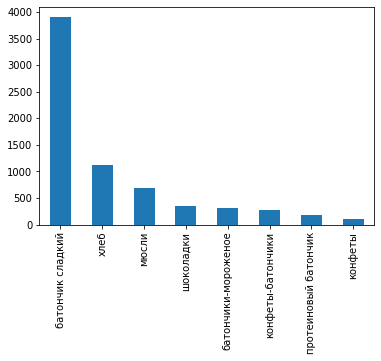

In [15]:
df['group'].value_counts().plot(kind='bar');

Как можно заметить выборка сильно смещенная

In [16]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['group_id'] = le.fit_transform(df['group'])

### Baseline

Попробуем реализовать самое простое решение и возьмем его за бейзлайн

In [17]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

y_train = df['group_id']
X_train = df['name']

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vect = CountVectorizer(ngram_range=(1, 3))
X_train_counts = vect.fit_transform(X_train)
clf = MultinomialNB().fit(X_train_counts, y_train)

y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

print(classification_report(y_train, y_train_pred, target_names=le.classes_))

                      precision    recall  f1-score   support

    батончик сладкий       0.97      0.92      0.94      3897
 батончики-мороженое       0.76      0.96      0.85       320
             конфеты       0.88      0.50      0.64       102
   конфеты-батончики       0.91      0.95      0.93       277
               мюсли       0.83      0.97      0.89       679
протеиновый батончик       0.74      0.73      0.73       176
                хлеб       0.99      1.00      0.99      1118
           шоколадки       0.82      0.87      0.84       355

            accuracy                           0.93      6924
           macro avg       0.86      0.86      0.85      6924
        weighted avg       0.93      0.93      0.93      6924



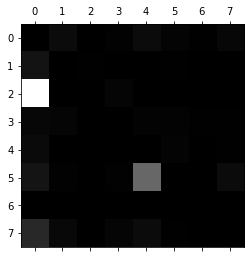

In [20]:
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
    
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Можно заметить, что модель получиась не очень хорошая, очень много миссов в конфетах, которые представлены самым меньшим кол-вом истансов.

Для начала попробуем учесть сокращения и различные формы слов, для этого разобьем слова на ngram:

In [21]:
list(vect.vocabulary_)[:20]

['бабаевский',
 'батончик',
 '50гр',
 'бабаевский батончик',
 'батончик 50гр',
 'бабаевский батончик 50гр',
 'батон',
 'молодежный',
 '38',
 'нарезка',
 'кхп',
 'батон молодежный',
 'молодежный 38',
 '38 нарезка',
 'нарезка кхп',
 'батон молодежный 38',
 'молодежный 38 нарезка',
 '38 нарезка кхп',
 'kхп',
 'нарезка kхп']

Как видно в некоторых случаях числа могут быть признаками товаров (38 копеек), а итогда просто масса, я бы попробовал убрать числа, т.к есть гипотиза, что названий товара с числом сильно меньше чем с массой

In [22]:
import re
def preprocess_text(text):
    text = re.sub(r'[^a-zа-я ]', ' ', text.lower())
    text = re.sub('\s+', ' ', text)

    return text

In [23]:
df['name'].apply(preprocess_text).head(20)

0                      бабаевский батончик гр
1               батон молодежный нарезка кхп 
2               батон молодежный нарезка kхп 
3      батон московский нарезка коломенское г
4                           батон нарезной кг
5                           батон нарезной kг
6          батон нарезной половинки в упак кг
7          батон нарезной половинkи в упаk kг
8            батон нарезной резаный в упак кг
9            батон нарезной резаный в упаk kг
10     батон нарезной нарезка нижегородский г
11        батон нарезной нарезка пролетарец г
12                    батон нарезной ручная г
13                            батон нарезной 
14                    батон нарезной нарезка 
15             батон нарезной нижегородский г
16             батон нарезной нижегородский г
17            батон подмосковный пролетарец г
18               батон с отрубями нар в уп кг
19               батон с отрубями нар в уп kг
Name: name, dtype: object

И попробуем использовать `TfidfVectorizer` чтобы учесть наиболее значимые слова, с разбивкой на ngram по чарам а не по словам

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

sw = stopwords.words('russian')
    
vect = TfidfVectorizer(
    analyzer='char_wb', 
    preprocessor=preprocess_text,
    stop_words=sw, 
    ngram_range=(3, 5),
    sublinear_tf=True)

X_train_counts = vect.fit_transform(X_train)
clf = MultinomialNB().fit(X_train_counts, y_train)

y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

print(classification_report(y_train, y_train_pred, target_names=le.classes_))

                      precision    recall  f1-score   support

    батончик сладкий       0.93      0.96      0.94      3897
 батончики-мороженое       0.98      0.92      0.95       320
             конфеты       0.00      0.00      0.00       102
   конфеты-батончики       0.97      0.93      0.95       277
               мюсли       0.78      0.95      0.86       679
протеиновый батончик       0.94      0.45      0.61       176
                хлеб       0.99      0.99      0.99      1118
           шоколадки       0.89      0.69      0.78       355

            accuracy                           0.92      6924
           macro avg       0.81      0.74      0.76      6924
        weighted avg       0.91      0.92      0.91      6924



In [25]:
list(vect.vocabulary_)[:20]

[' ба',
 'баб',
 'аба',
 'бае',
 'аев',
 'евс',
 'вск',
 'ски',
 'кий',
 'ий ',
 ' баб',
 'баба',
 'абае',
 'баев',
 'аевс',
 'евск',
 'вски',
 'ский',
 'кий ',
 ' баба']

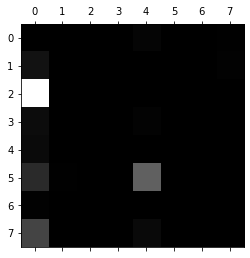

In [26]:
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
    
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Как видно, стало только хуже, давайте взглянем на 2 группу.

In [27]:
df[df['group_id'] == 2].head(20)

name    group  group_id
70                  169г конф киткат темн шок/вафл  конфеты         2
75              184ГР KОНФЕТЫ БАТОНЧИK ТВИKС МИНИС  конфеты         2
78    185ГР ШОKОЛАДНЫЙ БАТОНЧИK ТВИKС ИМБИРЬ МИНИС  конфеты         2
439                      бат. милки вей минис 176г  конфеты         2
2507          батончик милки вэй минис 176г<67397>  конфеты         2
2739         батончик несквик мини  с нугой  186гр  конфеты         2
3045   182ГР ШОKОЛАДНЫЕ БАТОНЧИKИ МАРС МИНИС ПАKЕТ  конфеты         2
3070                          бат. марс минис 182г  конфеты         2
3164        батончик твикс 184гр минис ц/уп россия  конфеты         2
3210              батончик твикс минис 184г<11882>  конфеты         2
3245                    Батончик ТВИКС minis 184гр  конфеты         2
3314           БАТОНЧИК ШОКОЛАДНЫЙ МАРС МИНИС 182Г  конфеты         2
3331                     батончики марс минис 180г  конфеты         2
3332             Батончики Марс Минис м/у 180-182г  конфеты         2
3334           БАТОНЧИK ШОKОЛАДНЫЙ МАРС МИНИС 182Г  конфеты         2
3356          Марс минис-Батончики шоколадные 182г  конфеты         2
3369                      Марс шок.батончик 182г*9  конфеты         2
3377                     МАРС ШОК.МИНИС ФАС.182 ГР  конфеты         2
3414              БАТОНЧИК ШОКОЛАДНЫЙ КИТ КАТ 200Г  конфеты         2
3430                     Мини батончики Марс 180г.  конфеты         2

In [28]:
df[df['group_id'] == 0].head(20)

name             group  \
20            "БАТОНЧИК МОНСТЕР 50г. арахис икарамель"  батончик сладкий   
31                                     батончик "снике  батончик сладкий   
32                       Батончик СЛАВЯНКА Лёвушка 40г  батончик сладкий   
43   /шоколад kit kat senses deluxe coconut  молочн...  батончик сладкий   
52                            07002 батончик твикс 55г  батончик сладкий   
53                  07003 батончик баунти молочный 55г  батончик сладкий   
54         1.кит-кат  батончик 1/112г senses кокос *16  батончик сладкий   
55                       1.несквик шок. бат. 28г. 30шт  батончик сладкий   
56   1/1 батончик капитан сильвер кокос шок/гл со с...  батончик сладкий   
57       112Г KИТ KАТ ШОKОЛАД SENSES KАРАМЕЛЬ KАПУЧИНО  батончик сладкий   
71          176ГР ШОKОЛАДНЫЕ БАТОНЧИKИ МИЛKИ ВЕЙ ПАKЕТ  батончик сладкий   
83         2.кит-кат  батончик 1/112г senses кокос *16  батончик сладкий   
84                        2.кит-кат  батончик 1/58г*35  батончик сладкий   
124                  26 ГР БАТОНЧИK МИЛKА TENDER BREAK  батончик сладкий   
128                             26г милки вей батончик  батончик сладкий   
129                         26Г ШОК.БАТОНЧИК МИЛКИ ВЭЙ  батончик сладкий   
130                  26Г ШОKОЛАДНЫЙ БАТОНЧИK МИЛKИ ВЭЙ  батончик сладкий   
136                 27307 шоколад кит кат батончик 40г  батончик сладкий   
144                   29Г KИТ KАТ ШОKОЛАД МОЛОЧНЫЙ 5ШТ  батончик сладкий   
145  3 ШОКОЛАД МОЛОЧНЫЙ C ХРУСТ. ВАФЛЕЙ "KIT KAT" (...  батончик сладкий   

     group_id  
20          0  
31          0  
32          0  
43          0  
52          0  
53          0  
54          0  
55          0  
56          0  
57          0  
71          0  
83          0  
84          0  
124         0  
128         0  
129         0  
130         0  
136         0  
144         0  
145         0

На первый взгляд я не оченб понимаю разницу между `батончик сладкий` и `конфеты`. Попробую дропнуть группу конфеты (слить группу `конфеты` в `батончик сладкий`?)

In [29]:
df = df[df['group_id'] != 2].copy()

In [60]:
le = preprocessing.LabelEncoder().fit(df['group'])
df['group_id'] = le.fit_transform(df['group'])

X_train = df['name']
y_train = df['group_id']

In [61]:
vect = TfidfVectorizer(
    analyzer='char_wb', 
    preprocessor=preprocess_text,
    stop_words=sw, 
    ngram_range=(3, 5),
    sublinear_tf=True)

X_train_counts = vect.fit_transform(X_train)
clf = MultinomialNB().fit(X_train_counts, y_train)

y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

print(classification_report(y_train, y_train_pred, target_names=le.classes_))

                      precision    recall  f1-score   support

    батончик сладкий       0.95      0.96      0.96      3897
 батончики-мороженое       0.98      0.92      0.95       320
   конфеты-батончики       0.97      0.93      0.95       277
               мюсли       0.78      0.95      0.86       679
протеиновый батончик       0.94      0.45      0.61       176
                хлеб       0.99      0.99      0.99      1118
           шоколадки       0.89      0.69      0.78       355

            accuracy                           0.94      6822
           macro avg       0.93      0.84      0.87      6822
        weighted avg       0.94      0.94      0.93      6822



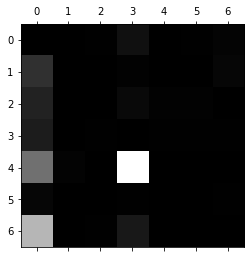

In [62]:
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
    
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Как можно заметить хуже всего работает классификация батончиков, ох уж эти батончики, и можно заметить, что чтобы классифицировать надо что более сложное, более качественно рзмеченные данные

Можно глянуть почему наш классификатор разметил протеинове батончики как мюсли:

In [63]:
res = pd.DataFrame({
     'name': df['name'],
     'y_train': y_train, 
     'y_train_pred': y_train_pred
})

miss = res[res['y_train_pred'] != res['y_train']]
miss[miss['y_train_pred'] == 3]

name  y_train  y_train_pred
247                       БАТ. НУТ 42г АРАХИС С КЛЮКВОЙ        0             3
259          4690677026678 батончик финтифант малин гла        0             3
398                     Батончик "Корнлайн" клюква 30гр        0             3
402                      Батончик "Корнлайн" кокос 30гр        0             3
612                      батончик клюква филевское 80 г        1             3
709            батон зерновой с семенами льна 280гр.фац        5             3
731                                        батон манана        5             3
732                                   батон манана 250г        5             3
1175                 батончик почему 35 в ассорт. 20 г.        0             3
1315         Батончик "Yarche" с семенами подсолн. 50гр        0             3
1465                   БАТОНЧ-М ЧЕРНИКА ЙОГУРТ FL 24Г /        0             3
1493                 Батончик "35" 20гр. в ассортименте        0             3
1672              Батончик "Фито Фрут" лесные ягоды 30г        4             3
1673                Батончик "ФитоФрут" 30гр в ассортим        4             3
1700                   БАТОНЧИК "BABYFOX" ГЕМОТОГЕН 40Г        0             3
1714        Батончик Нут&Го из арахиса с клюквой 42 гр.        0             3
1721                          батончик "ego" ассор. 35г        4             3
1735                  Батончик Пинкпи клубника 40гр 710        0             3
1736            Батончик "KitKat" Нazelnut 42г Германия        0             3
1768                    БАТОНЧИК С КЛЮКВОЙ КОРНЛАЙН 30Г        0             3
1790                Батончик "Tobleron" 100г в ассортим        6             3
1805  батончик 50 г капитан сильвер в белой глазури,...        0             3
1812               БАТОНЧИК АЛЕНКА МОЛОЧНО-ЗЛАКОВЫЙ 45Г        6             3
1814                    Батончик Аленка со злаками 48 г        6             3
1820       батончик амарантовый с лесными ягодами 20 г.        0             3
1821  батончик амарантовый с начинкой лесная ягода в...        0             3
1932  батончик бе-кинд ассорти с медом кленовым сиро...        6             3
1993                             батончик бутербр.200гр        0             3
2004                 Батончик Вдохновение 60гр в ассорт        6             3
2009       Батончик высокобелковый со вкусом банана 60г        0             3
...                                                 ...      ...           ...
4614                        батончик raw life кокос 47г        4             3
4621                    батончик raw life макадамия 47г        4             3
4697      батончик мюсли   в ас-те 40 гр  смарт формула        4             3
4712         батончик смарт бит лайт инж. апельс. 40 гр        4             3
4717          Батончик Смарт Формула в ассортименте 40г        4             3
4770                  батончики смарт формула мюсли 40г        4             3
4920                     Нестле Лайн-Батончик/Латте 42г        0             3
4934    орехово-фруктовый батончик "шоколад-протеин" шт        4             3
4965        рационика диет батончик ананас (глазир) 60г        0             3
4966  рационика диет батончик апельсин постный 50г а...        0             3
4967           рационика диет батончик глаз.  ананас60г        0             3
4968         рационика диет батончик кокос (глазир) 60г        0             3
4969           рационика диет батончик кофе постный 50г        0             3
4971      рационика лайт батончик глазиров черника 45,0        0             3
4972        рационика сахар-контроль батончик вишня 50г        0             3
4997                    Сдоба Фигурная батончик с маком        0             3
4998                 Сдоба фигурная Батончик с маком кг        0             3
5099       турбослим батончик белковый клуб чизкейк 50г        0             3
5100         турбослим батончик белковый шокол кекс 50г        0             3
5109  фитоидея батончи

In [64]:
miss[miss['y_train'] == 4].head()

name  y_train  y_train_pred
21    "БАТОНЧИК МОНСТР 50г. арахиснуга карамель"        4             0
1665         Батончик "ТУРБОСЛИМ" 50 гр в ассорт        4             0
1672       Батончик "Фито Фрут" лесные ягоды 30г        4             3
1673         Батончик "ФитоФрут" 30гр в ассортим        4             3
1721                   батончик "ego" ассор. 35г        4             3

In [65]:
df[df['group'] == 'мюсли'].head(20)

name  group  group_id
28   "Тимоша" Батончик мюсли Tekmar орех с тыквицей...  мюсли         3
30   Хрустящий батончик-мюсли с орехами 0,035г /Док...  мюсли         3
36             "Gerber" DOREMI Фруктовый батончик 25гр  мюсли         3
107           23.5Г БАТОНЧИК ЗЛАКОВЫЙ МОЛ.ШОКОЛАД КАРА  мюсли         3
117                   25Г БАТОНЧИК ЗЛАКОВЫЙ CINI-MINIS  мюсли         3
118            25Г БАТОНЧИК МЮСЛИ ФИТОИДЕЯ АССОРТИ РАЭ  мюсли         3
119  25ГР БАТОНЧИK МЮСЛИ МАЛИНА СО СЛИВKАМИ ДЕТСKИЙ...  мюсли         3
120  25ГР БАТОНЧИK МЮСЛИ ЧЕРНИKА+БЕЛЫЙ ШОKОЛАД ДЕТС...  мюсли         3
140              28175:киндер шоколад со злаками 23,5г  мюсли         3
149               30 ГР БАТОНЧИK МЮСЛИ МАЛИНА NUTBERRY  мюсли         3
150    30 ГР ФРУKТОВЫЙ БАТОНЧИK ФИНИK+АБРИKОС NUTBERRY  мюсли         3
151     30 ГР ФРУKТОВЫЙ БАТОНЧИK ФИНИK+KЛЮKВА NUTBERRY  мюсли         3
152                    30г батончик мюсли текмар вишня  мюсли         3
155     30ГР БАТОНЧИK ЗЛАKОВЫЙ МОЛОKО+KАKАО ОРЕХ CORNY  мюсли         3
161          3500 гР БАТОНЧИЕ МЮСЛИ С ЦУKАТАМИ "ВЕЛЛЕ"  мюсли         3
162         3500 гР БАТОНЧИЕ МЮСЛИ С KЛУБНИKОЙ "ВЕЛЛЕ"  мюсли         3
163  3500 гР ОРЕХОВО-ФРУKТОВЫЙ БАТОНЧИK NUTBERRY С ...  мюсли         3
168           "Яшкино" Батончик "CORNLINE" клюква 30гр  мюсли         3
169            "Яшкино" Батончик "CORNLINE" Кокос 30гр  мюсли         3
213                   БАТ. КОРНЛАЙН 30г ЗЛАКИ/КЛЮК/РИС  мюсли         3

In [66]:
from sklearn.svm import LinearSVC

clf = LinearSVC().fit(X_train_counts, y_train)
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

print(classification_report(y_train, y_train_pred, target_names=le.classes_))

                      precision    recall  f1-score   support

    батончик сладкий       0.95      0.98      0.97      3897
 батончики-мороженое       1.00      0.95      0.97       320
   конфеты-батончики       0.93      0.94      0.93       277
               мюсли       0.96      0.92      0.94       679
протеиновый батончик       0.89      0.74      0.81       176
                хлеб       0.99      0.99      0.99      1118
           шоколадки       0.95      0.83      0.89       355

            accuracy                           0.96      6822
           macro avg       0.95      0.91      0.93      6822
        weighted avg       0.96      0.96      0.96      6822



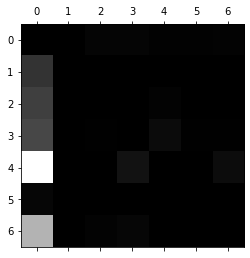

In [67]:
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
    
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [68]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier().fit(X_train_counts, y_train)
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

print(classification_report(y_train, y_train_pred, target_names=le.classes_))

                      precision    recall  f1-score   support

    батончик сладкий       0.94      0.97      0.96      3897
 батончики-мороженое       0.96      0.84      0.89       320
   конфеты-батончики       0.95      0.92      0.94       277
               мюсли       0.88      0.88      0.88       679
протеиновый батончик       0.87      0.69      0.77       176
                хлеб       0.98      0.97      0.98      1118
           шоколадки       0.90      0.79      0.84       355

            accuracy                           0.94      6822
           macro avg       0.93      0.87      0.89      6822
        weighted avg       0.94      0.94      0.94      6822



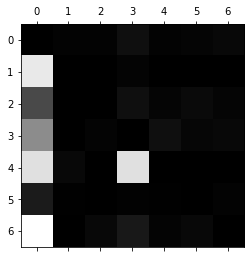

In [69]:
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
    
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Как можно заметить `LinearSVC` выдал самый высокий `acc` и `recall` поэтому можно поискать оптимальные гиперпараметры grid search'ем, но мы этого делать не будем, и просто реализуем knn на `с#` потому что это тестовое задание `¯\_(ツ)_/¯`

А если более серьезно подходить к делу, то можно посмотреть в сторону `эластика`, посгреса с `pg_trgm` и других баз с возможностью оценивать документы по схожести. Так же можно попробовать взять готовый word2vec на русском корпусе или натренировать свой чтобы использовать более умные эмбединги для классификаторов.
Так же я скачал базу товаров с группами golamago чтобы попробовать погонять классификатор на нем

In [75]:
raw = pd.read_json('../golamago/all_products2.json')

# В golamago группы иерархичные, поэтому мы избавляемся от top level групп
df = raw[raw['group_id'].str.len() < 7].copy()
df.drop_duplicates(inplace=True, subset='name')
groups_counts = df['group_id'].value_counts()
df = df[df['group_id'].isin(groups_counts[groups_counts > 100].index)]
df.reset_index(inplace=True, drop=True)

In [76]:
df['group_name'].nunique()

18

In [81]:
le = preprocessing.LabelEncoder().fit(df['group_name'])
df['group_id'] = le.fit_transform(df['group_name'])
y_train = df['group_id']

vect = TfidfVectorizer(
    analyzer='char_wb', 
    preprocessor=preprocess_text,
    stop_words=sw, 
    ngram_range=(3, 5),
    sublinear_tf=True)

X_train_counts = vect.fit_transform(df['name'])

clf = LinearSVC().fit(X_train_counts, y_train)
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)

print(classification_report(y_train, y_train_pred, target_names=le.classes_))

                                     precision    recall  f1-score   support

                         Автотовары       0.99      0.94      0.97       299
                            Бакалея       0.94      0.97      0.95      2087
     Бытовая химия, товары для дома       0.94      0.96      0.95      1274
      Готовые блюда и полуфабрикаты       0.87      0.78      0.82       402
                    Детское питание       0.98      0.93      0.96       495
          Консервированные продукты       0.92      0.93      0.93       582
                Косметика и гигиена       0.97      0.96      0.97      1907
            Молочные продукты, яйца       0.97      0.97      0.97      1456
                       Мясо и птица       0.95      0.98      0.97       562
Напитки, соки и безалкогольное пиво       0.97      0.99      0.98       936
        Овощи, фрукты, ягоды, грибы       0.94      0.85      0.89       368
                             Посуда       0.92      0.94      0.93       21

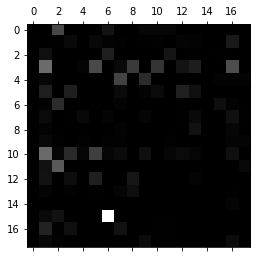

In [78]:
y_train_pred = cross_val_predict(clf, X_train_counts, y_train, cv=10)
conf_mx = confusion_matrix(y_train, y_train_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
    
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

И попробуем классифицировать наш исходный неразмеченный датасет:

In [82]:
X_train_counts = vect.transform(unlabeled['name'])

In [83]:
predict = clf.predict(X_train_counts)

In [84]:
predict

array([16,  7,  7, ...,  6,  6, 16])

array(['Хлеб и кондитерские изделия', 'Молочные продукты, яйца',
       'Молочные продукты, яйца', ..., 'Косметика и гигиена',
       'Косметика и гигиена', 'Хлеб и кондитерские изделия'], dtype=object)

In [92]:
result = pd.DataFrame({ 'name': unlabeled['name'], 'predicted': le.inverse_transform(predict) })

In [94]:
result[result['predicted'] == 'Косметика и гигиена']

name            predicted
231                       "ЧОКО ПАЙ" средн. Орион. 180г.  Косметика и гигиена
399                             "Orion" Choko Pie" 120гр  Косметика и гигиена
400                             "Orion" Choko Pie" 180гр  Косметика и гигиена
401                             "Orion" Choko Pie" 360гр  Косметика и гигиена
441                     [missha] misa cho gong jin cream  Косметика и гигиена
442                  [missha] misa cho gong jin emulsion  Косметика и гигиена
443                   [missha] misa cho gong jin essence  Косметика и гигиена
444                 [missha] misa cho gong jin eye cream  Косметика и гигиена
445    [tony moly] the chok chok green tea watery ess...  Косметика и гигиена
449    *EKEL МАСКА-ПЛЕНКА ДЛЯ ЛИЦА С ЭКСТРАКТОМ ЗЕЛЕН...  Косметика и гигиена
450    *ETUDE HOUSE КРЕМ ДЛЯ РУК С АРОМАТОМ ЗЕЛЕНОГО ...  Косметика и гигиена
451    *ETUDE HOUSE НОЧНАЯ МАСКА С ЭКСТРАКТОМ ЗЕЛЕНОГ...  Косметика и гигиена
452    *ETUDE HOUSE НОЧНАЯ МАСКА С ЭКСТРАКТОМ ЧЕРНОГО...  Косметика и гигиена
453    *INNISFREE КАПСУЛЬНАЯ МАСКА ДЛЯ ЛИЦА С ЭКСТРАК...  Косметика и гигиена
454    *KAPOUS ВОСК В КАРТРИДЖАХ С АРОМАТОМ ЗЕЛЕНОГО ...  Косметика и гигиена
469    0.5Л KОKТЕЙЛЬ CHOCOLATIER SHUSTOFF KОНЬЯЧНО-ШО...  Косметика и гигиена
516              1/1 rocs зубная паста шоколад/мята 74,0  Косметика и гигиена
665                     11017CASTOR мочалка массажная ША  Косметика и гигиена
719                     14554ECOLAB Kафе Kрасоты мыло Шо  Косметика и гигиена
750    150МЛ СПРЕЙ FA НАТУРАЛЬНАЯ СВЕЖЕСТЬ АРОМАТ БЕЛ...  Косметика и гигиена
761                     15953БЕЛИТА БЕЗУПРЕЧНАЯ ДЛИНА ша  Косметика и гигиена
774    160ГР СОЛЬ ШИПУЧАЯ ДЛЯ ВАННЫ "SPA BY LARA" ГОР...  Косметика и гигиена
813                     18266ANTI BOT подвеска д/туалета  Косметика и гигиена
834                     1942ЭЛЬФА Зеленая Аптека мыло Ча  Косметика и гигиена
908                     20070ANTI BOT подвеска д/туалета  Косметика и гигиена
947                     20131NATURA SIBERICA Бибеrika ша  Косметика и гигиена
948                     20133NATURA SIBERICA Бибеrika ша  Косметика и гигиена
995                     21650Таиланд Маска д/лица "24 ча  Косметика и гигиена
997                     21808ЛАKОМKА губная помада Шокол  Косметика и гигиена
998           21808ЛАKОМKА губная помада Шоколадный чизк  Косметика и гигиена
...                                                  ...                  ...
36272  FitoKосметик. Kрем-хна для бровей и ресниц Гор...  Косметика и гигиена
36275    gar олия краска д/волос 4.15 "морозный шоколад"  Косметика и гигиена
36276      garnier колор нэчралс №5.2500 горячий шоколад  Косметика и гигиена
36288  italwax solo воск плёночный д/депиляции "белый...  Косметика и гигиена
36422             KРАСKА ДЛЯ ВОЛОС ПАЛЛЕТ ТЕМНЫЙ ШОKОЛАД  Косметика и гигиена
36423                   KРАСKА ДЛЯ ВОЛОС GARNIER ШОKОЛАД  Косметика и гигиена
36424           KРАСKА ДЛЯ ВОЛОС PALETTE ГОРЯЧИЙ ШОKОЛАД  Косметика и гигиена
36438  kapous hy крем-краска д/волос  №5.8 (шоколад) ...  Косметика и гигиена
36458  l`oreal casting creme gloss краска д/волос 525...  Косметика и гигиена
36459  l`oreal casting creme gloss краска д/волос 535...  Косметика и гигиена
36462  lady henna краска травяная для волос шоколадны...  Косметика и гигиена
36463  lady`s бото-маска д/лица от мимических морщин ...  Косметика и гигиена
36469  LUKE ГИДРОГЕЛЕВЫЕ ПАТЧИ ДЛЯ КОЖИ ВОКРУГ ГЛАЗ С...  Косметика и гигиена
36470  LUKE МАСКА С ЭКСТРАКТОМ ЗЕЛЕНОГО ЧАЯ ДЛЯ ПРОБЛ...  Косметика и гигиена
36571  naturella женгигпрокл на каждый день green tea...  Косметика и гигиена
36641           palette  краска д/в  w2   темный шоколад  Косметика и гигиена
36642         pallete w2 краска д/волос (темный шоколад)  Косметика и гигиена
36647  prodigy краска д/волос 3,0 "тёмный шоколад" тё...  Косметика и гигиена
36648  pupa 00493200 тушь д/ресниц "vamp" 200 супер-о...  Косметика и гигиена
36692  schwarzkopf  igora royal крем-краска   4-6 сре...  Косметика и гиги

# Реализция на `c#`

In [1]:
!cat ../srv/KnnProductClassifier.cs

using System;
using System.IO;
using System.Linq;
using Newtonsoft.Json;

namespace flomly {
    public class KnnProductClassifier : IProductClassifier {
        readonly int _k;

        readonly IVectorEncoder _encoder;
        readonly SparseMatrix<int> _instances;
        readonly string[] _labels;

        public int InstanceCount => _labels.Length;

        // clone encoder before
        public KnnProductClassifier(Product[] instances, IVectorEncoder encoder, int k = 5) {
            var instancesVecotor = instances.Select(x => x.Name).ToArray();
            _encoder = encoder.Fit(instancesVecotor);
            _instances = _encoder.Transform(instancesVecotor);
            _labels = instances.Select(x => x.GroupName).ToArray();
            _k = k;
        }

        public (string, double) ClassifyByGroup(string name) {
            if (string.IsNullOrEmpty(name)) {
                throw new ArgumentException("message", nameof(name));
            }

            var vec = _encoder